In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Social networks: social signatures and weight-topology correlations**

In this exercise, we will do some weighted network analysis using a social network data set describing private messaging in a Facebook-like web-page (Data originally from http://toreopsahl.com/datasets/).
In the network, each node corresponds to a user of the website and link weights describe the total number of messages exchanged between users.

In the file `OClinks_w_undir.edg`, the three entries of each row describe one link:
`(node_i node_j w_ij)`,
where the last entry `w_ij` is the weight of the link between nodes `node_i` and `node_j`.

You can use this Jupyter notebook template to get started. Below, you can find some predefined functions that will be helpful to solve the problems. In most cases, you do not need to modify these functions (but do read them through and get an idea of what each of them are doing so that you can use them in your code). Fast forward and start modifying the code after the header **"Begin of the exercise"**.

Submit all your solutions to MyCourses as a single pdf report. Remember to include in your report all visualizations as well as all numerical and verbal answers to the questions of the exercise sheet.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.stats import binned_statistic

In [4]:
def create_linbins(start, end, n_bins):
    """
    Creates a set of linear bins.

    Parameters
    -----------
    start: minimum value of data, int
    end: maximum value of data, int
    n_bins: number of bins, int

    Returns
    --------
    bins: a list of linear bin edges
    """
    bins = np.linspace(start, end, n_bins)
    return bins

In [5]:
def create_logbins(start, end, n_log, n_lin=0):
    """
    Creates a combination of linear and logarithmic bins: n_lin linear bins
    of width 1 starting from start and n_log logarithmic bins further to
    max.

    Parameters
    -----------
    start: starting point for linear bins, float
    end: maximum value of data, int
    n_log: number of logarithmic bins, int
    n_lin: number of linear bins, int

    Returns
    -------
    bins: a list of bin edges
    """
    if n_lin == 0:
        bins = np.geomspace(start, end, num=n_log+1)
    elif n_lin > 0:
        bins = np.array([start + i for i in range(n_lin)]
                        + list(np.geomspace(start + n_lin, end, n_log+1)))
    return bins

## **Data**
Let us load the data from the right directory and assign the names for all the plots we will save. If you run this notebook in your machine, please specify the right directory.

In [6]:
path = "/content/drive/MyDrive/Complex Networks /OClinks_w_undir.edg"
network = nx.read_weighted_edgelist(path)

### **a) Complementary cumulative distributions**

Before performing a more sophisticated analysis, let us begin with taking a look at some basic network statistics to get a rough idea of what the network is like. To this end, **plot** the complementary cumulative distribution function (CCDF) for node degree $k$, node strength $s$ and link weight $w$.

- Show all three distributions in one plot using loglog-scale.
- The resulting distributions have *heavy tails*, meaning that the right part of the distributions decays slower than exponentially. To see this, **plot** in the same figure the CCDFs of exponential distributions having the same mean and variance as each empirical distribution.
- Based visually on the empirical CCDF plots, roughly **estimate** the 90th percentiles of the degree, strength, and weight distributions. **Explain** also how they can be read off from the plots.

First, let us get the node degrees and strengths.

**Coding hints**:

- A `nx.Graph` object reports the node degrees of the network through `degree` property, that is, you can access the set of node degrees of a `nx.Graph` object `net` by `net.degree` (or equivalently `net.degree()`).

- The node strength is the sum of weights of the links incident to the node, as compared to the degree which is the number of links incident to the node. You can obtain the node strengths using the same `net.degree()` method by passing the `weight` argument as `net.degree(weight='weight')`. Read also here: https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.degree.html

- Note that the above two functions will return an iterable over the (node, degree) pairs or (node, strength) pairs. In the following, you need to convert this into a list of degrees/strengths.

- As a check, calculate the maximum degree $k_\mathrm{max}$ and maximum strength $s_\mathrm{max}$. If everything is running okay so far, you should be getting $k_\mathrm{max}$ = 255 and $s_\mathrm{max}$ = 1546.0.

In [11]:
# Get the node degrees and strengths

degrees = nx.degree(network)
strengths = nx.degree(network, weight="weight")

# Now, convert the degree and strength into lists.
degree_vec = [d for n, d in degrees]
strength_vec = [s for n, s in strengths]

max_degree = max(degree_vec)
max_strength = max(strength_vec )

# Check the maxmimum degree and strength
print('Maximum degree: %d' % max_degree)
print('Maximum strength: %.1f' % max_strength)

Maximum degree: 255
Maximum strength: 1546.0


Next, let us get the link weights.

**Coding hints**:

- A `nx.Graph` object reports the edges of the network through `edges` property, that is, you can access the set of edges of a `nx.Graph` object `net` by `net.edges` (or equivalently `net.edges()`).

- The weight of each edge is stored as one of the attributes associated with the edge. If you want to obtain the edges of `net` with their edge attributes, use `net.edges(data=True)` or `net.edges.data()`. Both of them return the set of tuples `(i, j, data)` for each link `(i, j)` with a dictionary of attributes `data`.

- Then the information about the weight is stored as an entry in the dictionary `data`, which means you can access it by `data['weight']`.

- You can also skip generating the intermediary object `data` and directly access only the weights of the edges by using `net.edges.data('weight')`.

- Read more about using `edges` property here:
https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html

In [12]:
# Get the link weights
weights = [data['weight'] for i,j,data in network.edges(data=True)]
max_weight = max(weights)
print('Maximum weight: {}'.format(max_weight))

Maximum weight: 184.0


The following `plot_ccdf` function let you create CCDF plots. But you need to modify it first.

**Coding hints**:

Recall that a complementary cumulative distributions is defined as $P(X > x)$, the proportion of data points larger than value $x$, as a function of $x$. Especially you should keep in mind the following two points.

- $P(X > x)$ is a non-increasing function of $x$ because if you compare two values $x_1$ and $x_2$ where $x_1 > x_2$, you never find more data points above $x_1$ than above $x_2$.

- When you sort the data, $P(X > x)$ changes its value at every data point and remains constant between two data points with different values.

- See the binning tutorial provided on the course webpage for help on computing the CCDFs (1-CDFs).

In [29]:
from networkx.algorithms import coloring
def plot_ccdf(datavec, label, linestyle, color, ax):
    """
    Plots the complementary cumulative distribution function (CCDF) of the input data.

    Parameters
    -----------
    datavec: a list of data points
    label: str, label for the legend
    linestyle: str, style of the line
    color: str, color of the line
    ax: axis object where to plot
    """

    sorted_datavec = sorted(datavec)
    N = len(sorted_datavec)
    ccdf = np.zeros(N)

    for i, val in enumerate(sorted_datavec):
        for el in sorted_datavec:
            ccdf[i] += (el >= val)
        ccdf[i] /= N

    ax.plot(sorted_datavec, ccdf, linestyle=linestyle, label=label, color=color)

    return ax

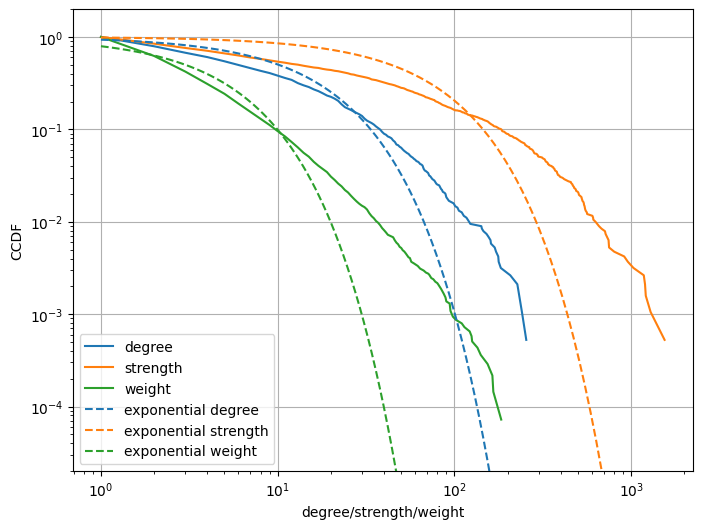

In [30]:
# Let us plot the empirical CCDFs
datavecs = [degree_vec, strength_vec, weights]
styles = ['-'] * 3
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['degree', 'strength', 'weight']
xlabel = 'degree/strength/weight'
ylabel = 'CCDF'

fig_ccdf, ax_ccdf = plt.subplots(figsize=(8, 6))
for datavec, label, style, color in zip(datavecs, labels, styles, colors):
    ax_ccdf = plot_ccdf(datavec, label, style, color, ax_ccdf)

# Now let us plot the exponential counterparts
labels_for_exp = ['exponential degree', 'exponential strength', 'exponential weight']
maximums = [max_degree, max_strength, max_weight]

# Get the mean degree, mean strength, and mean weight

mean_degree = sum(degree_vec) / len(degree_vec)
mean_strength = sum(strength_vec) / len(strength_vec)
mean_weight = sum(weights) / len(weights)

means = [mean_degree, mean_strength, mean_weight]

#Define the CCDF of a exponential distribution with mean mu
def ccdf_exp(x, mu):
    return 1 - (1 - np.exp(-x / mu))

for mean, maximum, label, color in zip(means, maximums, labels_for_exp, colors):
    x = np.geomspace(1, maximum, num=100)
    ax_ccdf.plot(x, ccdf_exp(x, mean), linestyle='--', color=color, label=label)

# Use loglog scale
ax_ccdf.set_xscale('log')
ax_ccdf.set_yscale('log')

ax_ccdf.set_xlabel(xlabel)
ax_ccdf.set_ylabel(ylabel)
ax_ccdf.legend()
ax_ccdf.set_ylim(bottom=2E-5, top=2)
ax_ccdf.grid()

In [31]:
import numpy as np

# Define the percentile you want to calculate (90th percentile)
percentile = 90

# Create a list to store the 90th percentiles for each dataset
percentiles = []

# Iterate through the datavecs list
for datavec in datavecs:
    # Sort the data in ascending order
    sorted_data = np.sort(datavec)

    # Calculate the index for the 90th percentile
    index = int(np.percentile(np.arange(len(sorted_data)), percentile))

    # Extract the value at the 90th percentile
    percentile_value = sorted_data[index]

    # Append the percentile value to the list
    percentiles.append(percentile_value)

# Print the 90th percentiles for each dataset
for i, dataset in enumerate(labels):
    print(f"90th Percentile for {dataset}: {percentiles[i]}")


90th Percentile for degree: 37
90th Percentile for strength: 183.0
90th Percentile for weight: 9.0


### **b) Average link weight per node**
Next, we will study how the average link weight per node $v =\frac{s}{k}$ behaves as a function of the node degree $k$.

- **Compute** $s$, $k$, and $v = \frac{s}{k}$ for each node.

- Make a **scatter plot** of all the data points of $v$ as a function of $k$. Create two versions of the plots: one with linear and one with logarithmic $x$-axes.

- The large variance of the data can make the scatter plots a bit messy. To make the relationship between $v$ and $k$ more visible, **create** bin-averaged versions of the plots, i.e., divide nodes into bins based on their degree and calculate the average $v$ in each bin. Plot the bin-averaged versions on top of the scatter plots.

- Based on the plots, **which** of the two approaches (linear or logarithmic $x$-axes) suits better for presenting $v$ as a function of $k$? **Why?**

**Hints**:
- For the bin-averaged plots, use bins that are consistent with the scale of the horizontal axis: bins with constant width for the linear scale and logarithmic bins for the logarithmic scale. If in trouble, see the binning tutorial for help.

- An example of how the scatter and bin-averaged plots may look like is shown in Fig.1 of the assignment PDF. Obviously, the number of bins are too few in these plots. Typically, it is better to use too many than too few bins. A good choice for the number of bins in this case would be 20.

- In the bin-averaged plot, the size of the points represents the number of nodes in each bin. Check if each degree bin includes roughly the same number of nodes. Unbalanced distribution of observations may obscure the results.

- `scipy.stats.binned_statistic` function is especially useful for answering this and the next questions.

In [ ]:
from scipy.stats import binned_statistic

In [14]:
def bin_averaged_plot(x, y, bins, ax):
    """
    Plots the bin-averaged values of y as a function of x.

    Parameters
    -----------
    x: x values, list or numpy array
    y: y values, list or numpy array
    bins: bin edges of x, list or numpy array
    ax: axis object where to plot, None or axis object
    xlabel: x label for the figure, string
    ylabel: y label for the figure, string
    """
    # bin-averaged values of x
    x_bin_averages, _, _ = binned_statistic(x, x, statistic='mean', bins=bins)

    # Calculate the bin-averaged values of y using binned_statistic
    y_bin_averages, _, _ = binned_statistic(x, y, statistic='mean', bins=bins)

    # Count the number of values in each bin.
    # This is used to calculate the size of the scatter points
    counts, _, _ = binned_statistic(x, x, statistic='count', bins=bins)

    # Plot the bin-averaged values
    ax.scatter(x_bin_averages, y_bin_averages, marker='o', color='r',
               s=2 * np.sqrt(counts), label='bin averages')

    return ax

In [ ]:
# average link weight per node (list or numpy array)
av_weight = []

#Calculate average link weight per node
av_weight = [s/k for s,k in zip(strength_vec,degree_vec)]

n_bins = 20
n_lin = 5
min_deg = min(degree_vec)
max_deg = max(degree_vec)

# Create linear and log bins
linbins = create_linbins(min_deg, max_deg, n_bins)
logbins = create_logbins(min_deg, max_deg, n_log=n_bins-n_lin, n_lin=n_lin)

# Take a look at the logarithmic bins
print(logbins)

[  1.           2.           3.           4.           5.
   6.           7.70389779   9.89167353  12.70074032  16.30753422
  20.93859614  26.88480077  34.51962621  44.32261203  56.90947883
  73.07080139  93.82166426 120.4654187  154.67554553 198.60076563
 255.        ]


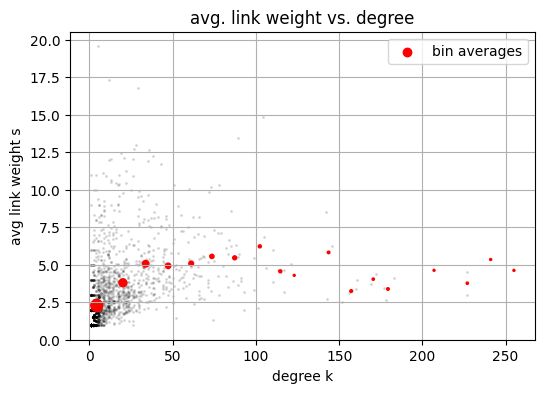

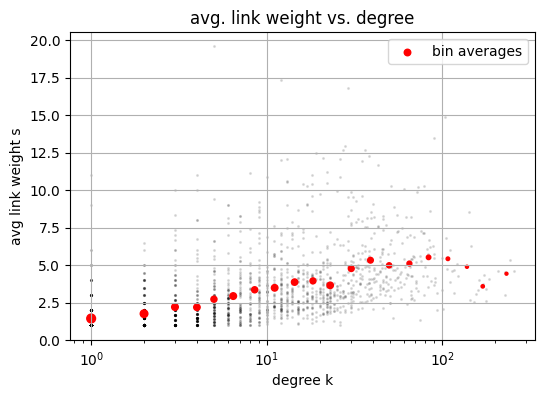

In [ ]:
alpha = 0.1 # transparency of data points in the scatter

# For each of linear and logarithmic versions, the full scatter plot and
# the bin-averaged plot should be shown in one figure.

for bins, scale in zip([linbins, logbins], ['linear', 'log']):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Scatter plot all data points on ax
    ax.scatter(degree_vec, av_weight, marker='o', color='k', s=1.5, alpha=alpha)

    # Plot the bin-averaged values on ax
    ax = bin_averaged_plot(degree_vec, av_weight, bins, ax)

    ax.set_xscale(scale)


    # Set appropriate labels
    ax.set_xlabel('degree k')
    ax.set_ylabel('avg link weight s')

    ax.set_ylim(bottom=0.0)
    ax.grid()

    ax.legend(loc='best')
    ax.set_title('avg. link weight vs. degree')

### **c) Social signature of egocentric networks**

Next, we will study the social signature of egocentric networks. The social signature of a node is a vector that describes the distribution of link weights in the egocentric network of the node. We define the social signature of node $i$ with degree $k_i$ as
$$
\mathbf{p}_i = \left( p_{i,1}, p_{i,2}, \ldots, p_{i,k_i} \right), \quad p_{i, 1} \geq p_{i, 2} \geq \ldots \geq p_{i, k_i},
$$
where $p_{i,j}$ is the weight of $j$-th link (sorted in the descending order) incident to node $i$ normalized by the sum of the weights of all links incident to $i$ (i.e., strength of node $i$) :
$$
p_{i,j} = \frac{w_{i,j}}{\sum_{j=1}^{k_i} w_{i,j}}.
$$

Here, your task is to **compute** the social signatures of the nodes in the network that have degree $k_i = 25$ and **visualize** the signatures $p_{i, j}$ as a function of rank $j$.

In [32]:
def social_signature(G, node):
    """Calculate the social signature of a node in a network.

    Parameters
    ----------
    G : NetworkX graph
        The network of interest
    node : int
        The node of interest

    Returns
    -------
    signature : np.ndarray
        The social signature of the node, i.e., the tie strengths between
        the node and its neighbors, normalized by the sum and sorted in
        ascending order.
    """
    neighbors = list(G.neighbors(node))
    weights = [G[node][neighbor]['weight'] for neighbor in neighbors]
    sum_weights = sum(weights)
    normalized_weights = [w / sum_weights for w in weights]
    sorted_normalized_weights = sorted(normalized_weights, reverse=True)
    signature = np.array(sorted_normalized_weights)
    return signature

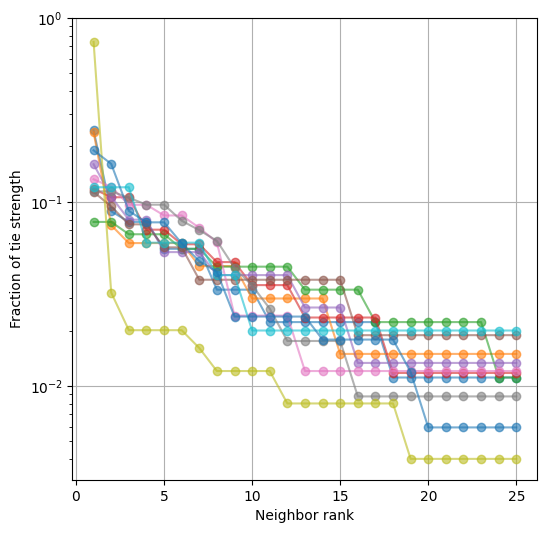

In [33]:
nodes_k = []
#Get all the nodes with degree 25 and store them in nodes_k
nodes_k = [node for node in network.nodes() if network.degree(node) == 25]

# Plot social signatures of nodes with degree 25
fig_signature, ax_signature = plt.subplots(figsize=(6, 6))
for node in nodes_k:
    signature = social_signature(network, node)
    rank = np.arange(1, len(signature) + 1)
    ax_signature.plot(rank, signature, 'o-', alpha=0.6)
ax_signature.set_yscale('log')
ax_signature.set_ylim(top=1)
ax_signature.set_xlabel('Neighbor rank')
ax_signature.set_ylabel('Fraction of tie strength')
plt.grid()
plt.show()

### **d) Link neighborhood overlap**
Let's consider a link between nodes $i$ and $j$. For this link, *link neighborhood overlap* $O_{ij}$ is defined as the fraction of common neighbors of $i$ and $j$ out of all their neighbors: $O_{ij}=\frac{n_{ij}}{\left(k_i-1\right)+\left(k_j-1\right)-n_{ij}}.$

According to the Granovetter hypothesis, link neighborhood overlap is an increasing function of link weight in social networks. Your task is now to find out whether this is the case also for the present data set by visualizing it in an appropriate way. Use the binning strategy (linear or logarithmic) that is most suitable for this case.

- **Calculate** the link neighborhood overlap for each link. To do this, you will need to modify the `get_link_overlap` function.

- Create a **scatter plot** showing the overlaps as a function of link weight.

- As in b), **produce** also a bin-averaged version of the plot on top of the scatter plot. In doing this, choose a reasonable number of bins, which, in this case, will be between 10 and 30. **Specify** how many bins you used.

- In the end, you should be able to spot a subtle trend in the data. Based on your plot, **comment on** if the trend is in accordance with the Granovetter hypothesis.

**Coding hints**:

- For getting common neighbors of two nodes, you can use `set` datatype and `intersection()` method.

- Naive implementation of the above definition of $O_{ij}$ will result in ZeroDivisionError for some links. Examine for what kind of links this happens. What would be the appropriate way to define $O_{ij}$ for those links?

In [34]:
def get_link_overlap(net):
    """
    Calculates link overlap:
    O_ij = n_ij / [(k_i - 1) + (k_j - 1) - n_ij]

    Parameters
    -----------
    net: a networkx.Graph() object

    Returns
    --------
    overlaps: list of link overlaps in net
    """

    # Write a function to calculate link neighborhood overlap
    # Hint: for getting common neighbors of two nodes, use
    # set datatype and intersection method

    overlaps = []

    for edge in net.edges():
        node_i, node_j = edge
        neighbors_i = set(net.neighbors(node_i))
        neighbors_j = set(net.neighbors(node_j))
        common_neighbors = neighbors_i.intersection(neighbors_j)

        k_i = len(neighbors_i)
        k_j = len(neighbors_j)
        n_ij = len(common_neighbors)

        if (k_i - 1) + (k_j - 1) - n_ij != 0:
            overlap = n_ij / ((k_i - 1) + (k_j - 1) - n_ij)
        else:
            overlap = 0.0

        overlaps.append(overlap)

    return overlaps

[  1.           2.           3.           4.           5.
   6.           7.538108     9.47051203  11.89829041  14.94843302
  18.78048375  23.59488579  29.64346621  37.24260828  46.78980055
  58.78442829  73.85389483  92.78643921 116.57236658 146.45584813
 184.        ]


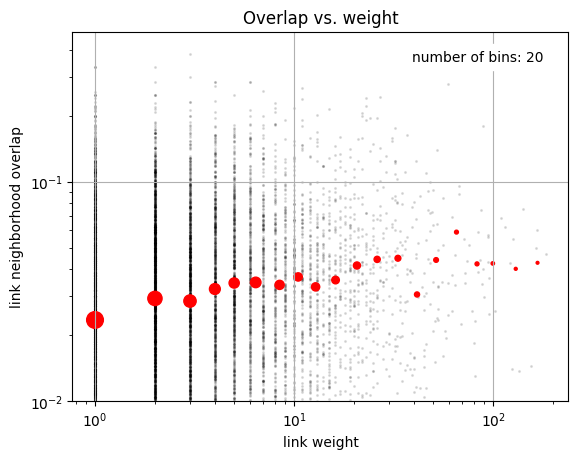

In [37]:
overlaps = get_link_overlap(network)
alpha = 0.1 # transparency of data points in the scatter

n_bins = 20
n_lin = 5
min_w = np.min(weights)
max_w = np.max(weights)

linbins = create_linbins(min_w, max_w, n_bins)
logbins = create_logbins(min_w, max_w, n_log=n_bins-n_lin, n_lin=n_lin)
print(logbins)

# TODO: try both linear and logarithmic bins, select the better one
# Specify the scale for axis that is consitent with the binning strategy
bins = logbins #YOU CAN CHANGE THEM
scale = 'log'

# creating link neighborhood overlap scatter
fig_lno, ax_lno = plt.subplots()

ax_lno.scatter(weights, overlaps, marker='o', color='k', s=1.5, alpha=alpha)
ax_lno = bin_averaged_plot(weights, overlaps, bins, ax_lno)
ax_lno.set_xscale(scale)
ax_lno.set_yscale('log')
ax_lno.set_ylim(bottom=0.01)
ax_lno.grid()


#Set appropriate labels
ax_lno.set_xlabel('link weight')
ax_lno.set_ylabel('link neighborhood overlap')

ax_lno.text(0.95, 0.95, "number of bins: {}".format(n_bins),
        horizontalalignment='right', verticalalignment='top',
        backgroundcolor='w', transform=ax_lno.transAxes)

ax_lno.set_title('Overlap vs. weight')
plt.show()
